### Set directory and session info

In [75]:
date = '181031'
larvaID = 'Larva_3'
fov = 'FOV2'
genoType = 'nsyb-LexA x LexA-GCaMP7b'
sensor = 'GCaMP7b'
imgPath = '/Volumes/genie/Jihong_GENIE_stuff/NMJ/GCaMP7/' + date + '/' + larvaID + '/' + fov
# imgPath = '/Users/zhengj10/Desktop/data/'+ date + '/' + larvaID + '/' + fov


### Import modules

In [76]:
import numpy as np
import re
import thunder
import sys
import os
# from sima.misc.imagej import read_imagej_roi_zip
from read_roi import read_roi_zip
from shapely.geometry import MultiPolygon, Point
from shapely.geometry import Polygon as shapelyPolygon
from itertools import product as product
import tifffile as tff
from extraction.model import ExtractionModel
from glob import glob


### Thunder extration

In [77]:
sumPath = imgPath + '/summary'
roiLoadName = sumPath+ '/RoiSet.zip'
roiList = read_roi_zip(roiLoadName)
numOfRois = len(roiList.keys())
print ('Number of ROIs: ' + str(numOfRois))
rois = []
for roi in(roiList.keys()):
    rois.append([roiList[roi]['x'],roiList[roi]['y']])


Number of ROIs: 6


In [59]:
# roiEdge = rois[4]['polygons']
# roiEdge[:,0]

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

In [54]:
img = tff.TiffFile(os.path.join(sumPath, 'meanOfImg_020Hz.tif'))
img = img.asarray()

In [55]:
img = np.mean(img, axis = 0)

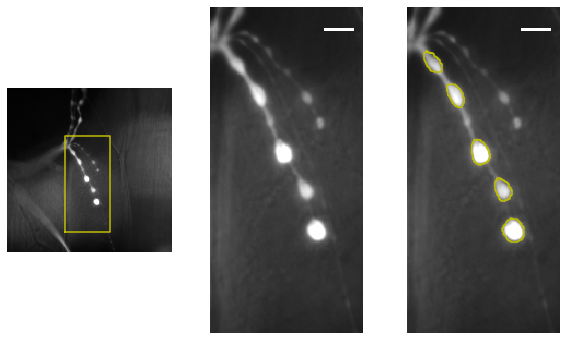

In [74]:
xStart = 150
xEnd = 450
yStart = 180
yEnd = 320
vmin = img.min()
vmax = img.max()*0.75

# from matplotlib import gridspec
fig = plt.figure(figsize=(10, 6)) 
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, (xEnd-xStart)/512.0])
ax1 = plt.subplot(1,3,1)
ax1.imshow(img, cmap = 'gray', vmin = vmin, vmax = vmax)
ax1.plot([yStart,yEnd,yEnd,yStart,yStart],[xEnd,xEnd,xStart,xStart,xEnd],'y')
ax2 = plt.subplot(1,3,2)
ax2.imshow(img[xStart:xEnd, yStart:yEnd], cmap = 'gray', vmin = vmin, vmax = vmax)
ax2.plot([105,130],[20,20], 'w', lw=3)
ax3 = plt.subplot(1,3,3)
ax3.imshow(img[xStart:xEnd, yStart:yEnd], cmap = 'gray', vmin = vmin, vmax = vmax)
ax3.plot([105,130],[20,20], 'w', lw=3)
for roiNum in range(5):
    roiEdge = rois[roiNum]
    ax3.plot(np.array(roiEdge[0]) - yStart , np.array(roiEdge[1]) - xStart, 'y')
# plt.xlim(0,512)
# plt.ylim(512,0)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()
# fig.savefig('/Users/zhengj10/Desktop/boutons.png', dpi=1200)


In [ ]:
# roiCenter = []
# for point in (roiCoordinates):
#     a = int(point.x)
#     b = int(point.y)
#     roiCenter.append([a,b])
# roiCenter


In [ ]:
def computeDff(singleTrace, shutterCloseFrames = 12, stimStart = 3527.8, frameInterval = 33, fb = 0):
    stopFrame = int(stimStart//frameInterval) - shutterCloseFrames
    startFrame = stopFrame - 15
    f0 = np.mean(singleTrace[startFrame : stopFrame])
    df = singleTrace - f0
    dff = df/(f0-fb)
    return f0, dff

### Reshape data format

In [ ]:
raw_AllTrials_ROIs = []
f0_AllTrials_ROIs = []
dff_AllTrials_ROIs = []
for trialNum in range(numOfTrials):
    raw_SingleTrial_ROIs = []
    f0_SingleTrial_ROIs = []
    dff_SingleTrial_ROIs = []
    for roiNum in range(numOfRois):
        raw = traces[trialNum]
        f0, dff = computeDff(raw[roiNum])
        raw_SingleTrial_ROIs.append(raw[roiNum,:])
        f0_SingleTrial_ROIs.append(f0)
        dff_SingleTrial_ROIs.append(dff)
    raw_AllTrials_ROIs.append(raw_SingleTrial_ROIs)
    f0_AllTrials_ROIs.append(f0_SingleTrial_ROIs)
    dff_AllTrials_ROIs.append(dff_SingleTrial_ROIs)
print ('Raw traces stored in list')
print ('Dff traces stored in list')
raw_AllTrials_ROIs_asArray = np.array(raw_AllTrials_ROIs)
dff_AllTrials_ROIs_asArray = np.array(dff_AllTrials_ROIs)
print (raw_AllTrials_ROIs_asArray.shape)
print (dff_AllTrials_ROIs_asArray.shape)


In [ ]:
# raw_AllTrials_ROIs = []
# f0_AllTrials_ROIs = []
# dff_AllTrials_ROIs = []
# for trialNum in range(numOfTrials):
#     raw_SingleTrial_ROIs = []
#     dff_SingleTrial_ROIs = []
#     for roiNum in range(numOfRois):
#         raw = traces[trialNum]
#         f0 = np.mean(raw[roiNum,73:88]) # Use mean of 15 frames before stimulation as F0
#         df = raw[roiNum,:] - f0
#         dff = df/f0
#         raw_SingleTrial_ROIs.append(raw[roiNum,:])
#         dff_SingleTrial_ROIs.append(dff)
#     raw_AllTrials_ROIs.append(raw_SingleTrial_ROIs)
#     dff_AllTrials_ROIs.append(dff_SingleTrial_ROIs)
# print ('Raw traces stored in list')
# print ('Dff traces stored in list')
# raw_AllTrials_ROIs_asArray = np.array(raw_AllTrials_ROIs)
# dff_AllTrials_ROIs_asArray = np.array(dff_AllTrials_ROIs)
# print (raw_AllTrials_ROIs_asArray.shape)
# print (dff_AllTrials_ROIs_asArray.shape)


### Save traces and ROI coordinates to mat file

In [ ]:
import scipy.io as sio

sio.savemat(sumPath + '/' + '_raw.mat', dict(raw=raw_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_f0.mat', dict(f0=f0_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_dff.mat', dict(dff=dff_AllTrials_ROIs))
# scipy.io.savemat(matlabPath + '/' + '_roiCenter.mat', dict(roiCenter=roiCenter))


### Single ROI for all trials & all ROIs for single trial

In [ ]:
# Single ROI for all trials
trialMap = {1: '1 Hz',
            2: '5 Hz',
            3: '10 Hz',
            4: '20 Hz',
            5: '40 Hz',
            6: '80 Hz',
            7: '160 Hz' 
              }

roiNum = 1
numOfFrames = dff_AllTrials_ROIs_asArray.shape[2]

plt.figure(figsize=(5,5))

ax1 = plt.subplot(121)
for trialNum in range (numOfTrials):
    ax1.plot(dff_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=0.7, label=trialMap[trialNum+1])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title(sensor)
ax1.set_xlabel('Frame #', size=12)
ax1.set_ylabel('dF/F', size=12)
ax1.get_ylim()

# All ROIs for all trials

ax2 = plt.subplot(122)
for trialNum in range (numOfTrials):
    mean = np.mean(dff_AllTrials_ROIs_asArray[trialNum, :, 50:], axis=0)
    error = np.std(dff_AllTrials_ROIs_asArray[trialNum, :, 50:], axis=0)/(dff_AllTrials_ROIs_asArray[trialNum, :, 50:].shape[0]-1)
    ax2.plot(np.arange(1, numOfFrames+1-50), mean, lw=0.7, label=trialMap[trialNum+1])
    ax2.fill_between(np.arange(1, numOfFrames+1-50),mean-error, mean+error, alpha=0.5)
leg2 = ax2.legend()
leg2.get_frame().set_linewidth(0.0)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title(sensor)
ax2.set_xlabel('Frame #', size=12)
ax2.set_ylabel('dF/F', size=12)
# plt.ylim(-0.2,3.2)
# ax2.set_ylim(ax1.get_ylim())
plt.show()
# ax1.get_ylim()[1]


### Single ROI for all trials & all ROIs for single trial (raw data)

In [ ]:
# Single ROI for all trials
trialMap = {1: '1 Hz',
            2: '5 Hz',
            3: '10 Hz',
            4: '20 Hz',
            5: '40 Hz',
            6: '80 Hz',
            7: '160 Hz' 
              }

roiNum = 0
numOfFrames = dff_AllTrials_ROIs_asArray.shape[2]
plt.figure(figsize=(6,6))

ax1 = plt.subplot(121)
for trialNum in range (numOfTrials):
    ax1.plot(raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=0.7, label=trialMap[trialNum+1])
leg1 = ax1.legend()
leg1.get_frame().set_linewidth(0.0)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title(sensor)
ax1.set_xlabel('Frame #', size=12)
ax1.set_ylabel('F', size=12)


# All ROIs for single trial
trialNum = 4

ax2 = plt.subplot(122)
for roiNum in range (numOfRois):
    ax2.plot(raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=0.5, label='Roi_' + str(roiNum+1))
leg2 = ax2.legend()
leg2.get_frame().set_linewidth(0.0)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title(sensor)
ax2.set_xlabel('Frame #', size=12)
ax2.set_ylabel('F', size=12)
plt.show()
